In [1]:
# imports
from load_data import load_dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re


In [2]:
# Load Data
fp = "/Users/augusttollerup/Documents/SEM4/Fagprojekt/Data/agg-cleaned.csv"

df = load_dataset(fp, type="pandas", sep=",")
print(df.columns)

load_dataset - Filepath: /Users/augusttollerup/Documents/SEM4/Fagprojekt/Data/agg-cleaned.csv
Loaded dataset to Pandas DataFrame
Index(['meter_id', 'type', 'timeslot', 'num_kwh', 'spot_price_no_vat',
       'amount_no_vat', 'amount_with_vat', 'vat_percent', 'ediel_product_code',
       'kwh_fee_no_vat'],
      dtype='object')


In [4]:
df_prod = df[df["type"] == "production"]
df_prod.reset_index(drop=True, inplace=True)

df_cons = df[df["type"] == "consumption"]
df_cons.reset_index(drop=True, inplace=True)



In [3]:
# Print unique timeslots
print("Timeslots in entire dataset: ",len(df["timeslot"]))
print("Timeslots in production: ",len(df_prod["timeslot"]))
print("Timeslots in consumption: ",len(df_cons["timeslot"]))

Timeslots in entire dataset:  17934937
Timeslots in production:  4568586
Timeslots in consumption:  9956353


In [6]:
# Get index for timeslot = 01-01-2018 00:01:00

def create_ideal_index(index_start, index_end):
    new_index = pd.date_range(start = index_start, end = index_end, freq = "1H")
    # Convert new_index to string
    new_index = [str(x) for x in new_index]
    return new_index


In [7]:
def plot_missing_dates_on_timeline(start, end, missing, title = "Missing timeslots"):
    """Plot missing dates on timeline

    Args:
        min (datetime): start date on timeline
        max (datetime): end date on timeline
        missing (list): list of missing dates in the interval
        title (str, optional): Plot title. Defaults to "Missing timeslots".
    """
    
    # Plot missing timeslot values 
    # Inspired by https://matplotlib.org/3.5.1/gallery/lines_bars_and_markers/timeline.html

    # Choose some nice levels
    levels = np.tile([-5, 5, -3, 3, -1, 1],
                    int(np.ceil(len(missing)/6)))[:len(missing)]

    # Create figure and plot a stem plot with the date
    fig, ax = plt.subplots(figsize=(8.8, 4), constrained_layout=True)
    ax.set(title=title)

    ax.vlines(missing, 0, levels, color="tab:red")  # The vertical stems.
    ax.plot(missing, np.zeros_like(missing), "-o",
            color="k", markerfacecolor="w")  # Baseline and markers on it.

    # remove y axis and spines
    ax.yaxis.set_visible(False)
    ax.spines[["left", "top", "right"]].set_visible(False)

    # Set x-axis interval
    ax.set_xlim(start, end)

    ax.margins(y=0.1)
    plt.show()

In [8]:
def plot_missing_timeslots(start, end, ideal, missing, title = "Missing timeslots"):
    first_timeslot = start
    last_timeslot = end

    # Set first and last element of ideal to x_labels
    x_labels = missing.copy()
    x_labels[0] = first_timeslot
    x_labels[-1] = last_timeslot

    # plot dot on horisontal line for ideal timeslots
    plt.rcParams["figure.figsize"] = (22,3)
    plt.plot(ideal, [0] * len(ideal), "-o", markerfacecolor="none", markeredgecolor="black", markersize=1)
    # Show only first and last x-axis label
    # Plot vertical line for missing timeslots with red dot
    plt.vlines(missing, 0, 1, color="red", linewidth=1, label="Missing", alpha=0.5, linestyle="--")
    # Rotate x-axis labels
    plt.xticks([first_timeslot] + missing + [last_timeslot], rotation=90)
    plt.legend()
    plt.title(title)
    plt.show()



In [9]:
# Get unique meter_ids
meter_ids_unique = df_prod.meter_id.unique()
print(len(meter_ids_unique))

542


In [10]:
# Fix timeslot
def fix_timeslot(timeslot):
    # # Match +01 and +01:00
    # re_match = r"(\+01:00|\+01)"
    
    # # Convert from summer to winter time
    # if re.findall(re_match, timeslot) != []:
    #     print("Found summer time for first timeslot: ", timeslot)
    #     # Convert to timestamp
    #     timeslot = pd.to_datetime(timeslot)
    #     # Convert from +01:00 to +02:00
    #     timeslot = timeslot - pd.Timedelta(hours=1)
    #     # Convert back to string
    #     timeslot = str(timeslot).replace("+01:00", "+02").replace("+01", "+02")

    # Pandas convert +01:00 to +02:00
    timeslot = pd.to_datetime(timeslot)
    timeslot = timeslot.tz_convert(tz = "GMT")
    # Convert to string
    timeslot = str(timeslot)
    
    return timeslot


In [23]:
# Loop through meter_ids and calculate yearly coverage
full_coverage_meter_ids = []

# Define dataset to use
df_loop = df_cons

df_coverages = pd.DataFrame(columns=["meter_id", "year_coverage", "first_timeslot", "last_timeslot"])

for idx, meter_id in enumerate(meter_ids_unique):
    timeslots_for_meter = sorted(df_loop[df_loop["meter_id"] == meter_id]["timeslot"].values)

    # Convert timeslot to UTC
    timeslots_for_meter = [pd.to_datetime(x).tz_convert("UTC").strftime("%Y-%m-%d %H:%M:%S+00:00") for x in timeslots_for_meter]

    # Get first and last timeslot
    first_timeslot = fix_timeslot(str(timeslots_for_meter[0]))
    last_timeslot = fix_timeslot(str(timeslots_for_meter[-1]))

    # print("First timeslot: ", first_timeslot)
    # print("Last timeslot: ", last_timeslot)

    new_index = create_ideal_index(first_timeslot, last_timeslot)

    # print("New index first timeslot: ", new_index[0])
    # print("New index last timeslot: ", new_index[-1])

    overlap = list(set(timeslots_for_meter) & set(new_index))
    missing = list(set(new_index) - set(timeslots_for_meter))
    
    # Calculate overlap percentage
 
    coverage = len(overlap) / len(new_index) * 100
    print("Meter_id: ", meter_id, " Coverage: ", coverage, ", ", idx, " out of ", len(meter_ids_unique))
    df_coverages.loc[idx] = [meter_id, coverage, first_timeslot, last_timeslot]


Meter_id:  0148117f-53bb-48ca-ae71-1523f099fb81  Coverage:  100.0 ,  0  out of  542
Meter_id:  028b54e1-6594-4fca-ba0d-bfbb5f9a8b6f  Coverage:  100.0 ,  1  out of  542
Meter_id:  05afdd22-3570-4e5b-b4d2-6719ac8af2ac  Coverage:  84.44467223617447 ,  2  out of  542
Meter_id:  08ef7b1d-5f62-46df-92fe-167ebc2229d7  Coverage:  93.1456953642384 ,  3  out of  542
Meter_id:  0afd188d-d511-46c5-99e6-1754b2c92091  Coverage:  68.38905775075987 ,  4  out of  542
Meter_id:  0d54d233-15a2-4253-a38a-69f325dc3ee7  Coverage:  100.0 ,  5  out of  542
Meter_id:  0fbb107a-9d54-42bf-b203-6cbb4f6fbc4f  Coverage:  100.0 ,  6  out of  542
Meter_id:  130ddc31-15a9-4caf-b077-b9919b98b87a  Coverage:  100.0 ,  7  out of  542
Meter_id:  13da9e23-eabe-4ecc-bf19-19482c05117f  Coverage:  100.0 ,  8  out of  542
Meter_id:  13e046fd-9a37-4f50-b2ec-10427527fa39  Coverage:  96.0386857445681 ,  9  out of  542
Meter_id:  14338d78-9f43-4fa6-ba70-e719a4d45025  Coverage:  95.98691384950926 ,  10  out of  542
Meter_id:  1909a2

In [24]:
df_coverages = df_coverages.sort_values(by="year_coverage", ascending=False)
print(df_coverages.head())

                                 meter_id  year_coverage  \
0    0148117f-53bb-48ca-ae71-1523f099fb81          100.0   
308  bf1f9a38-e811-4378-8810-1cb774773e2d          100.0   
359  ffde7516-88ea-4e11-a4e5-d87fd8618288          100.0   
356  e1b0c487-90fb-4cb6-b996-7448d3a833d7          100.0   
355  d8bf786c-c211-4cd3-8dae-b15a6b3e0050          100.0   

                first_timeslot              last_timeslot  
0    2016-11-08 23:00:00+00:00  2018-04-30 21:00:00+00:00  
308  2017-04-25 22:00:00+00:00  2019-05-14 21:00:00+00:00  
359  2018-02-27 23:00:00+00:00  2019-05-14 21:00:00+00:00  
356  2018-05-20 22:00:00+00:00  2018-11-08 22:00:00+00:00  
355  2018-05-27 22:00:00+00:00  2019-01-21 22:00:00+00:00  


In [25]:
# Save to csv
df_coverages.to_csv("year_coverage_consumption.csv", index=False)

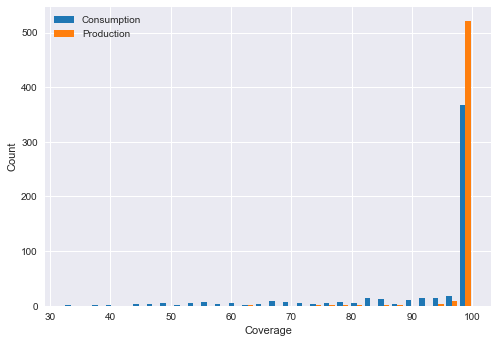

In [26]:
# Load csv
df_coverages_cons = pd.read_csv("year_coverage_consumption.csv")
df_coverages_prod = pd.read_csv("year_coverage_production.csv")
# Round to 1 decimal
df_coverages_cons["year_coverage"] = df_coverages_cons["year_coverage"].round(2)
df_coverages_prod["year_coverage"] = df_coverages_prod["year_coverage"].round(2)

# Plot  
# Set plot background color
plt.style.use('seaborn')
plt.hist([df_coverages_cons["year_coverage"],df_coverages_prod["year_coverage"]], bins=30, label=["Consumption", "Production"],
                    color=["tab:blue", "tab:orange"])
plt.ylabel("Count")
plt.xlabel("Coverage")
plt.legend(["Consumption", "Production"])
plt.show()


In [28]:
# Find meters with 100% coverage
df_coverages_cons_100 = df_coverages_cons[df_coverages_cons["year_coverage"] == 100]
df_coverages_prod_100 = df_coverages_prod[df_coverages_prod["year_coverage"] == 100]

print(r"Meters with 100% coverage: ", len(df_coverages_cons_100), " out of ", len(df_coverages_cons))
print(r"Meters with 100% coverage: ", len(df_coverages_prod_100), " out of ", len(df_coverages_prod))

Meters with 100% coverage:  358  out of  542
Meters with 100% coverage:  478  out of  542


In [48]:
# For each meter caluclate the time between first and last timeslot
df_coverages_cons_100["time_between_first_last"] = pd.to_datetime(df_coverages_cons_100["last_timeslot"]) - pd.to_datetime(df_coverages_cons_100["first_timeslot"])
df_coverages_prod_100["time_between_first_last"] = pd.to_datetime(df_coverages_prod_100["last_timeslot"]) - pd.to_datetime(df_coverages_prod_100["first_timeslot"])

# Convert time_between_first_last to years
df_coverages_cons_100["time_between_first_last"] = df_coverages_cons_100["time_between_first_last"] / pd.Timedelta(days=365)
df_coverages_prod_100["time_between_first_last"] = df_coverages_prod_100["time_between_first_last"] / pd.Timedelta(days=365)

# Return only meters with more than 1 year of coverage
df_coverages_cons_100 = df_coverages_cons_100.loc[df_coverages_cons_100["time_between_first_last"] > 1]
df_coverages_prod_100 = df_coverages_prod_100.loc[df_coverages_prod_100["time_between_first_last"] > 1]

print(r"Consumption Meters with more than 1 year of 100% coverage: ", len(df_coverages_cons_100), " out of ", len(df_coverages_cons))
print(r"Production Meters with more than 1 year of 100% coverage: ", len(df_coverages_prod_100), " out of ", len(df_coverages_prod))

# Save to csv
df_coverages_cons_100.to_csv("year_coverage_consumption_100.csv", index=False)
df_coverages_prod_100.to_csv("year_coverage_production_100.csv", index=False)

SyntaxError: unexpected EOF while parsing (410552070.py, line 20)